# Profile

Nama  : Tiwa Ramdhani

Email : tiwaramdhani@gmail.com

Kabupaten Bandung, Jawa Barat

# Import Library

In [ ]:
!pip install -U split_folders

Requirement already up-to-date: split_folders in /usr/local/lib/python3.7/dist-packages (0.4.3)


In [2]:
import numpy as np
import zipfile,os
from google.colab import files
import time

from keras.preprocessing.image import ImageDataGenerator
import splitfolders
from keras.preprocessing import image

import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Conv2D , Flatten , Dropout , Activation, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

path = "/tmp/rockpaperscissors/"

ModuleNotFoundError: ignored

# Download Dataset and Extract to Directory

In [ ]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-06-05 04:41:22--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  3.49MB/s    in 89s     

2021-06-05 04:42:52 (3.44 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [ ]:
zip_file = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Split Dataset

In [ ]:
splitfolders.ratio(path+"rps-cv-images", output="output", seed=1337, ratio=(0.6, 0.4))

Copying files: 2188 files [00:01, 1749.85 files/s]


In [ ]:
path_train = "output/train/"
path_val = "output/val/"

# Image Augmentation

In [ ]:
image_width = 150
image_height = 150

In [ ]:
dataGen = ImageDataGenerator(width_shift_range=0.2,
                            height_shift_range=0.1,
                            zoom_range=0.3,
                            rotation_range=10,
                            zca_whitening=False,
                            horizontal_flip=True,
                            vertical_flip=True,
                            featurewise_std_normalization=False,
                            rescale=1./255,
                            featurewise_center=False,
                            preprocessing_function=preprocess_input,
                            shear_range = 0.3,
                            fill_mode="reflect")

test_gen = ImageDataGenerator(rescale=1./255,
                              preprocessing_function=preprocess_input)


train_generator = dataGen.flow_from_directory(
        path_train,  
        target_size=(150, 150),  
        batch_size=15,
        class_mode='categorical')

val_generator = test_gen.flow_from_directory(
        path_val,  
        target_size=(150, 150),
        batch_size=10,
        class_mode='categorical')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


# CNN Model

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adamax(),
              metrics=['CategoricalAccuracy', 'MeanSquaredError'])

In [ ]:
class TrainTime(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)
        print("Training Time : {} minutes".format(round(sum(self.times)/60,2)))

In [ ]:
cb_earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
cb_md_save = ModelCheckpoint('model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
timer = TrainTime()

# Traning and Evaluating Model

In [ ]:
hist = model.fit(train_generator, epochs = 25, steps_per_epoch=30, validation_data=(val_generator), validation_steps=15, callbacks=[cb_earlystop, cb_md_save, timer])

Epoch 1/25
30/30 [==============================] - 57s 861ms/step - loss: 1.0922 - categorical_accuracy: 0.4122 - mean_squared_error: 0.2206 - val_loss: 1.0134 - val_categorical_accuracy: 0.5867 - val_mean_squared_error: 0.2029
Training Time : 0.95 minutes
Epoch 2/25
30/30 [==============================] - 25s 835ms/step - loss: 0.6881 - categorical_accuracy: 0.7136 - mean_squared_error: 0.1304 - val_loss: 0.9147 - val_categorical_accuracy: 0.5800 - val_mean_squared_error: 0.1809
Training Time : 1.36 minutes
Epoch 3/25
30/30 [==============================] - 25s 819ms/step - loss: 0.3697 - categorical_accuracy: 0.8852 - mean_squared_error: 0.0635 - val_loss: 0.7893 - val_categorical_accuracy: 0.8733 - val_mean_squared_error: 0.1509
Training Time : 1.77 minutes
Epoch 4/25
30/30 [==============================] - 25s 832ms/step - loss: 0.3813 - categorical_accuracy: 0.8789 - mean_squared_error: 0.0678 - val_loss: 0.7385 - val_categorical_accuracy: 0.8133 - val_mean_squared_error: 0.14

In [ ]:
model_load = keras.models.load_model("/content/model.hdf5")

In [ ]:
model_load.evaluate(val_generator)

88/88 [==============================] - 14s 150ms/step - loss: 0.0516 - categorical_accuracy: 0.9840 - mean_squared_error: 0.0083


[0.05163669213652611, 0.9840182662010193, 0.00826189573854208]

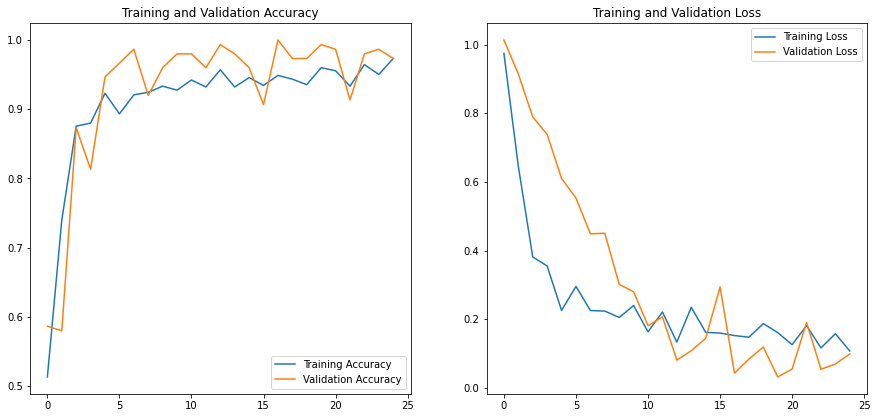

In [ ]:
ctg_acc = hist.history['categorical_accuracy']
val_ctg_acc = hist.history['val_categorical_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(25)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, ctg_acc, label='Training Accuracy')
plt.plot(epochs_range, val_ctg_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test Model With Uploaded Image

Saving WhatsApp Image 2021-05-31 at 17.29.28.jpeg to WhatsApp Image 2021-05-31 at 17.29.28 (2).jpeg
paper


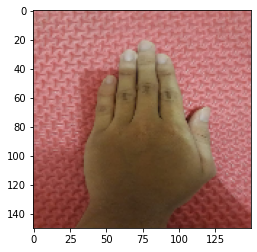

In [ ]:
uploaded = files.upload()
 
for path in uploaded.keys():

  img = image.load_img(path, target_size=(150,150,3))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  
  x = np.vstack([x])
  classes = model_load.predict(x, batch_size=15)
  classes = np.argmax(classes)

  if classes==0:
    print('paper')
  elif classes==1:
    print('rock')
  else:
    print("scissor")